In [2]:
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2
log_problem = pd.read_csv('Log_Problem.csv')
info_userdata = pd.read_csv('Info_UserData.csv')

In [3]:
log_problem['timestamp_TW'] = log_problem['timestamp_TW'].apply(lambda x: dt.datetime.strptime(x[:-4], "%Y-%m-%d %H:%M:%S"))

NameError: name 'dt' is not defined

In [5]:
# for each student, what was the avg time they spent per problem? 
avg_time_problem = log_problem.groupby(by='uuid')['total_sec_taken'].mean()

# student accuracy
student_accuracy = log_problem.groupby(by='uuid')['is_correct'].mean()

# no. of upgrades and downgrades
n_upgrades = log_problem.groupby(by='uuid')['is_upgrade'].sum()
n_downgrades = log_problem.groupby(by='uuid')['is_downgrade'].sum()

# no. of hints used per qns attempted
n_hints_per_attempted = log_problem.groupby(by='uuid')['is_hint_used'].mean()



import datetime as dt
# log_problem['timestamp_TW'] = log_problem['timestamp_TW'].apply(lambda x: dt.datetime.strptime(x[:-4], "%Y-%m-%d %H:%M:%S"))
log_problem.sort_values(by='timestamp_TW', ascending=True, inplace=True)



# shift cols down by 1
log_problem['ucid_shifted'] = log_problem.groupby(by='uuid', sort=False)['ucid'].shift(1)
log_problem['timestamp_shifted'] = log_problem.groupby(by='uuid', sort=False)['timestamp_TW'].shift(1)


# keep relevant rows
mask = (log_problem['ucid']!=log_problem['ucid_shifted']) & (log_problem['ucid_shifted'].notna())
relevant_logs = log_problem[mask]

# find time diff
relevant_logs['time_diff'] = (relevant_logs['timestamp_TW'] - relevant_logs['timestamp_shifted']).dt.total_seconds()

# get avg time
avg_time = relevant_logs.groupby(by='uuid')['time_diff'].mean()



# merge everything together
avg_time_problem.name = 'avg_time_per_problem'
student_accuracy.name = 'avg_accuracy'
n_downgrades.name = 'n_downgrades'
n_upgrades.name = 'n_upgrades'
n_hints_per_attempted.name = 'n_hints_per_attempted'
avg_time.name = 'avg_time_btwn_ex'

clustering_input = pd.concat([avg_time_problem, student_accuracy, n_downgrades, n_upgrades, n_hints_per_attempted,
                              avg_time], axis=1)


cols_wanted = ['points', 'badges_cnt', 'user_grade', 'has_teacher_cnt', 'has_student_cnt', 'has_class_cnt',
               'belongs_to_class_cnt']

clustering_input = clustering_input.merge(info_userdata[cols_wanted + ['uuid']], left_index=True, right_on='uuid')
clustering_input.set_index('uuid', inplace=True)

clustering_input.fillna(0, inplace=True)

C:\Anaconda\envs\tf3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
features = ['is_correct', 'is_hint_used', 'total_sec_taken', 'total_attempt_cnt']

# Example features
def aggregate_log(data, by, features):
    mean_features = data[[by]+features].groupby([by]).mean().reset_index()
    return mean_features
  
user_log = aggregate_log(log, 'uuid', features)


In [ ]:
bt4103Preprocessor.scale_numerical_data(clustering_input)

### Begin clustering WITHOUT PCA

In [ ]:
# unique_id = user_log.iloc[:,0:1]
# data = user_log.iloc[:,1:]
k_range = np.arange(2,8) # should start with 2 cluster at least
# clustering_scores = pd.DataFrame()
seed = 4103

user_log = clustering_input.reset_index()

from clustering_utils.clustering_pipeline import bt4103Clustering
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS, Birch, AffinityPropagation
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import GaussianMixture

CC = bt4103Clustering(user_log)
CC.create_algo_input(inputs = [(KMeans, {'random_state':seed}, ('n_clusters', k_range)),
         (GaussianMixture, {'random_state':seed}, ('n_components', k_range)),]
    )
# CC.clustering_preprocessing(n_components=None)
scores, unique_id = CC.run_clustering_pipeline()
CC.silhouette_analysis()

### Begin clustering with all PCA components

Finished 'clustering_preprocessing' in 1.396 secs
Beginning iteration for KMeans
Finished 'run_clustering' in 339.191 secs
Finished iteration for KMeans

Finished 'run_clustering_pipeline' in 339.206 secs


C:\Anaconda\envs\tf3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Anaconda\envs\tf3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


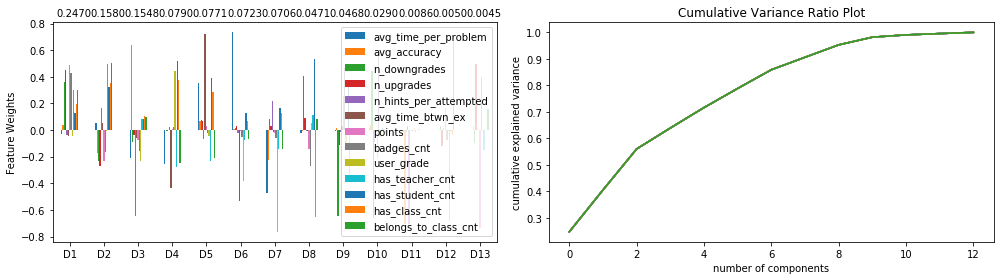

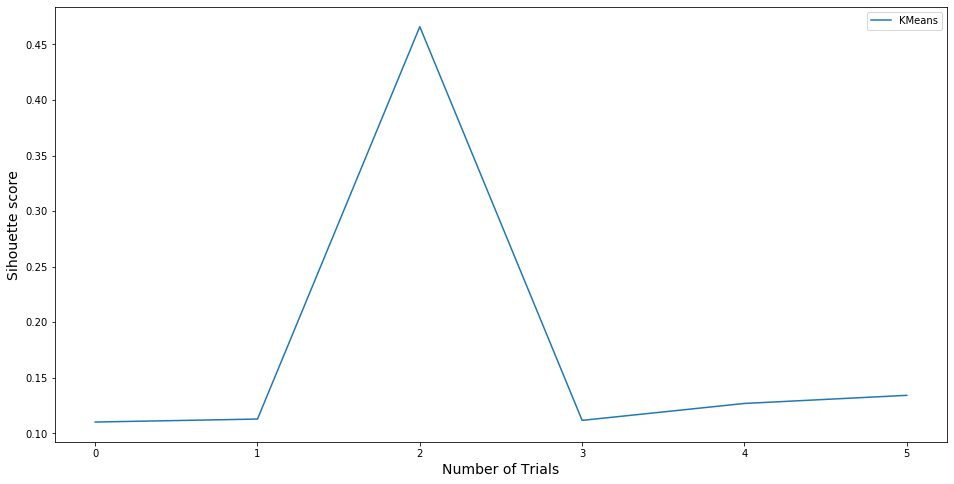

In [14]:
# unique_id = user_log.iloc[:,0:1]
# data = user_log.iloc[:,1:]
k_range = np.arange(2,8) # should start with 2 cluster at least
# clustering_scores = pd.DataFrame()
seed = 4103

user_log = clustering_input.reset_index()

from clustering_utils.clustering_pipeline import bt4103Clustering
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS, Birch, AffinityPropagation
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import GaussianMixture

CC = bt4103Clustering(user_log)
CC.create_algo_input(inputs = [(KMeans, {'random_state':seed}, ('n_clusters', k_range)),
#          (GaussianMixture, {'random_state':seed}, ('n_components', k_range)),
                              ]
    )
CC.clustering_preprocessing(n_components=None)
scores, unique_id = CC.run_clustering_pipeline()
CC.silhouette_analysis()

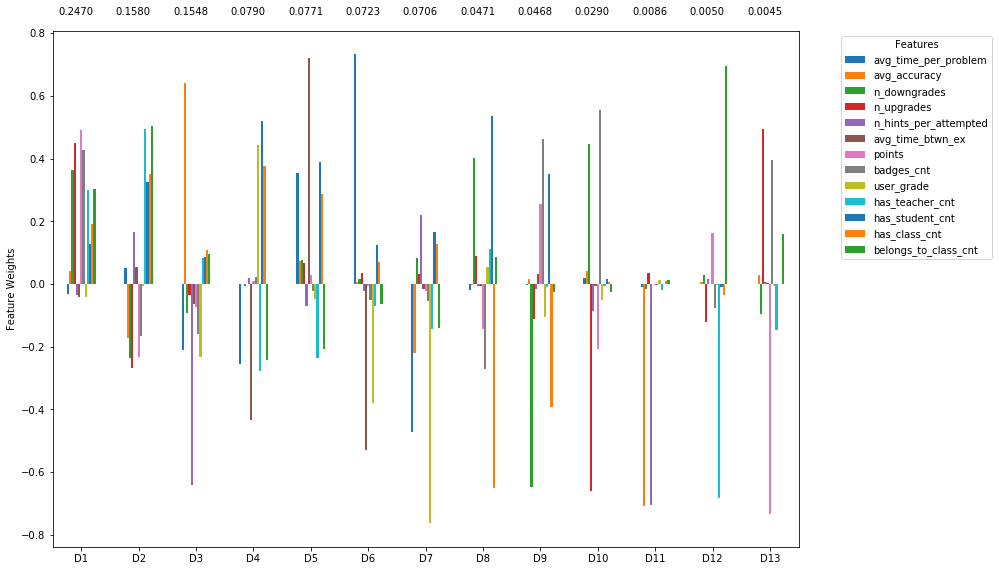

In [15]:
CC.preprocessor.plot_pca_result()

In [20]:
best_model_col = [col for col in CC.clustering_groups if CC.best_model.__class__.__name__ in col]
user_log['best_cluster'] = CC.clustering_groups[best_model_col]
user_log['best_cluster'].value_counts()

0    68720
3     2395
2     1149
1      494
Name: best_cluster, dtype: int64

C:\Anaconda\envs\tf3\lib\site-packages\sklearn\decomposition\_base.py:131: RuntimeWarning: invalid value encountered in true_divide
  X_transformed /= np.sqrt(self.explained_variance_)


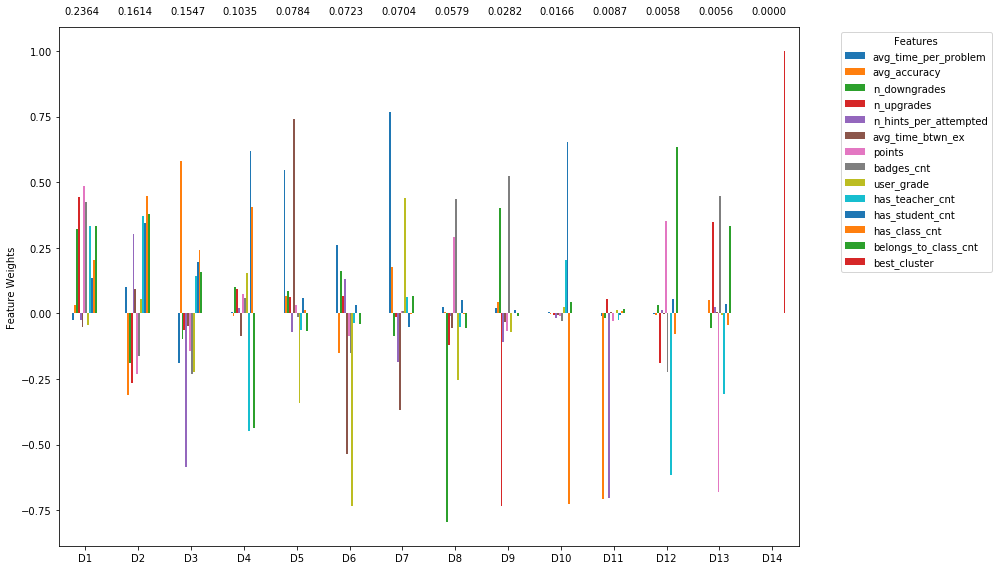

In [40]:
# PCA(random_state = 2).fit(user_log[user_log['best_cluster']==1].iloc[:,1:]).explained_variance_ratio_
bt4103Preprocessor(user_log[user_log['best_cluster']==0].iloc[:,1:]).plot_pca_result(n_components=None, seed=3124)

C:\Anaconda\envs\tf3\lib\site-packages\sklearn\decomposition\_base.py:131: RuntimeWarning: invalid value encountered in true_divide
  X_transformed /= np.sqrt(self.explained_variance_)


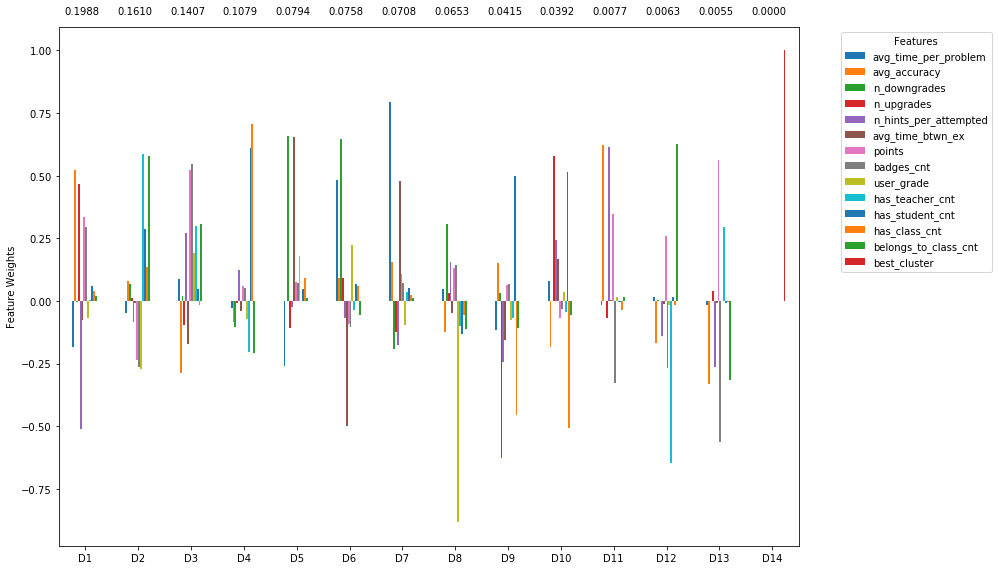

In [34]:
from sklearn.decomposition import PCA
from clustering_utils.clustering_preprocessor import bt4103Preprocessor

# PCA(random_state = 2).fit(user_log[user_log['best_cluster']==1].iloc[:,1:]).explained_variance_ratio_
bt4103Preprocessor(user_log[user_log['best_cluster']==1].iloc[:,1:]).plot_pca_result(n_components=None, seed=3124)

C:\Anaconda\envs\tf3\lib\site-packages\sklearn\decomposition\_base.py:131: RuntimeWarning: invalid value encountered in true_divide
  X_transformed /= np.sqrt(self.explained_variance_)


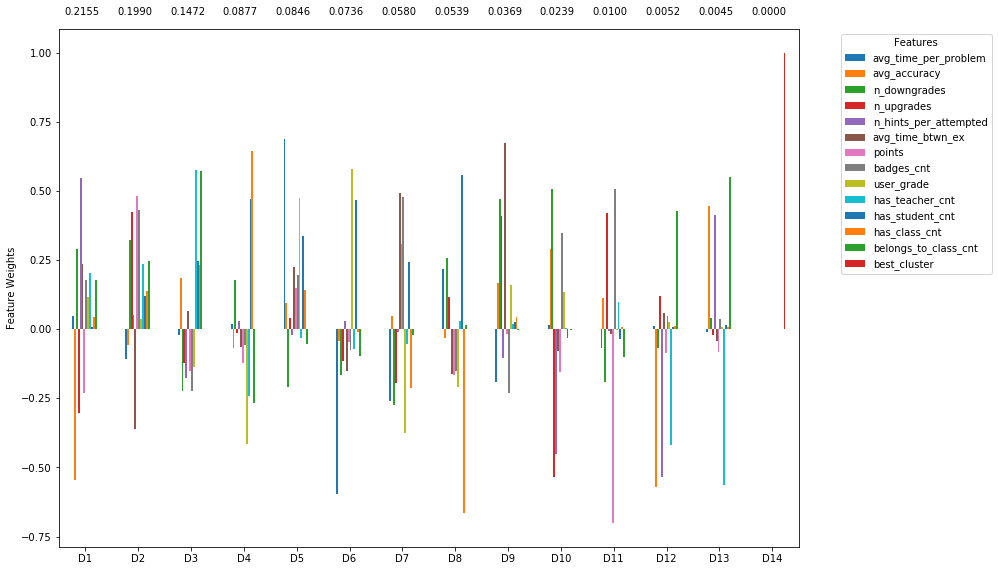

In [36]:
from sklearn.decomposition import PCA
# PCA(random_state = 2).fit(user_log[user_log['best_cluster']==1].iloc[:,1:]).explained_variance_ratio_
bt4103Preprocessor(user_log[user_log['best_cluster']==2].iloc[:,1:]).plot_pca_result(n_components=None, seed=3124)

C:\Anaconda\envs\tf3\lib\site-packages\sklearn\decomposition\_base.py:131: RuntimeWarning: invalid value encountered in true_divide
  X_transformed /= np.sqrt(self.explained_variance_)


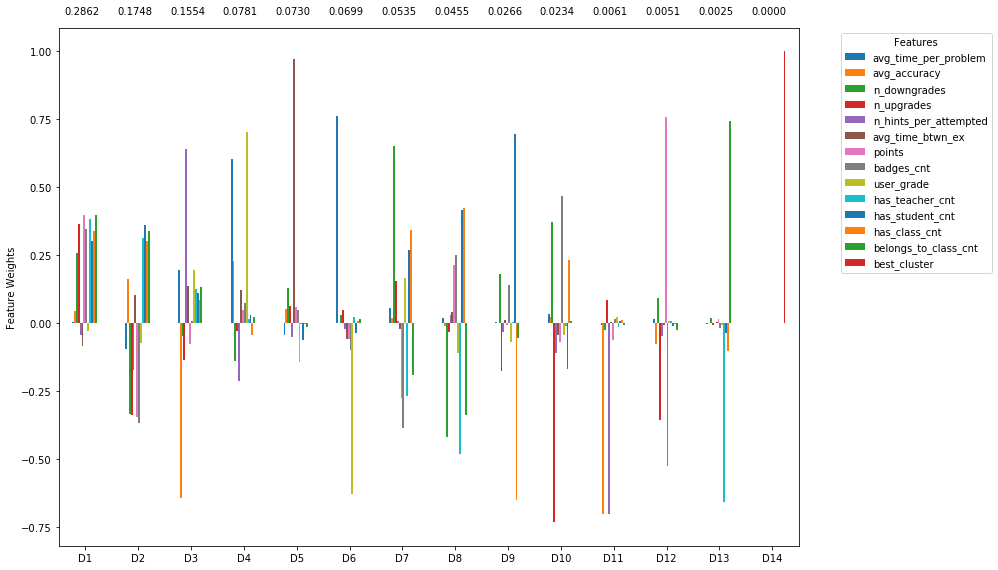

In [38]:
from sklearn.decomposition import PCA
# PCA(random_state = 2).fit(user_log[user_log['best_cluster']==1].iloc[:,1:]).explained_variance_ratio_
bt4103Preprocessor(user_log[user_log['best_cluster']==3].iloc[:,1:]).plot_pca_result(n_components=None, seed=3124)

In [44]:
user_log

,uuid,avg_time_per_problem,avg_accuracy,n_downgrades,n_upgrades,n_hints_per_attempted,avg_time_btwn_ex,points,badges_cnt,user_grade,has_teacher_cnt,has_student_cnt,has_class_cnt,belongs_to_class_cnt
0,++5bdNp/LZvGenJ8Brp4n2SfS9d4pu4qA7cF7FQW7hk=,60.400000,1.000000,0,1,0.000000,0.000000,16725,1,7,1,0,0,1
1,++9EkR6syMGk44XpyhOj40cg9xiXwCLS/TwEy+ujrL0=,14.758621,0.103448,0,0,0.724138,0.000000,1200,3,7,1,0,0,1
2,++E4TrlDYvGtPBg1edhkLXLEEbnfiAgAamPQ33vpW8M=,89.800000,0.700000,0,1,0.300000,0.000000,9533,0,5,1,0,0,1
3,++G4mkLfs4WDYhc1Ga+3G+/oqSniQQvLBm7SBQ3V39Y=,37.804878,0.560976,0,2,0.439024,30985.714286,8027,0,6,1,0,0,1
4,++GobOSWqrsaxoRg1bMN+T6biIJcgBXwuOH/ddq3DiU=,31.890323,0.883871,0,19,0.032258,48624.107143,41831,2,7,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72753,zztwLsjf44Uzumou84qh04wObpugkIllLCIp/mgoMu8=,130.307692,0.884615,0,4,0.115385,7275.000000,7500,0,9,1,0,0,1
72754,zzueVRV14tXIEgW4ixiqmtPNaFYz4MIifbMM/H2tmqA=,87.333333,0.666667,0,3,0.259259,120.000000,3750,0,4,0,0,0,0
72755,zzujjvdKzb4wL8cFKdF3Of5gg2XHzIDQCZ2TfaYpSNs=,46.907173,0.552743,0,17,0.295359,192896.703297,33370,4,3,3,0,0,4
72756,zzvvUOwcSXXTXd8xoyimNcm2DjeVPLmZAI19WKfhSAM=,10.217391,0.956522,0,3,0.043478,150.000000,7995,1,5,1,0,0,0


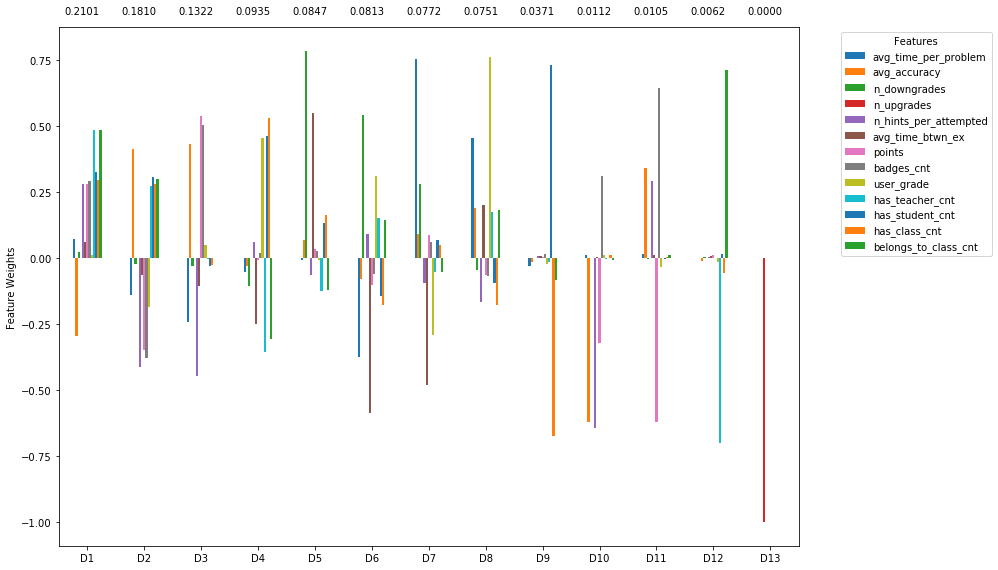

In [48]:
from sklearn.decomposition import PCA
# PCA(random_state = 2).fit(user_log[user_log['best_cluster']==1].iloc[:,1:]).explained_variance_ratio_
# bt4103Preprocessor()
bt4103Preprocessor(user_log[user_log['n_upgrades']==1].iloc[:,1:]).plot_pca_result(n_components=None, seed=3124)

### Being clustering with number of components set to contain 0.99 variance of the data

Finished 'clustering_preprocessing' in 2.983 secs
Beginning iteration for KMeans
Finished 'run_clustering' in 761.826 secs
Finished iteration for KMeans

Finished 'run_clustering_pipeline' in 761.981 secs


C:\Anaconda\envs\tf3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Anaconda\envs\tf3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


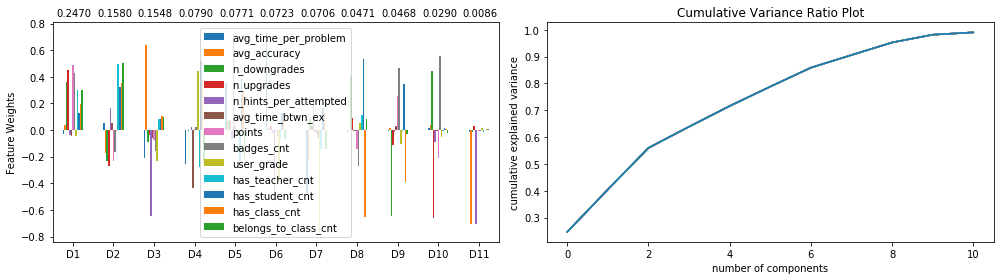

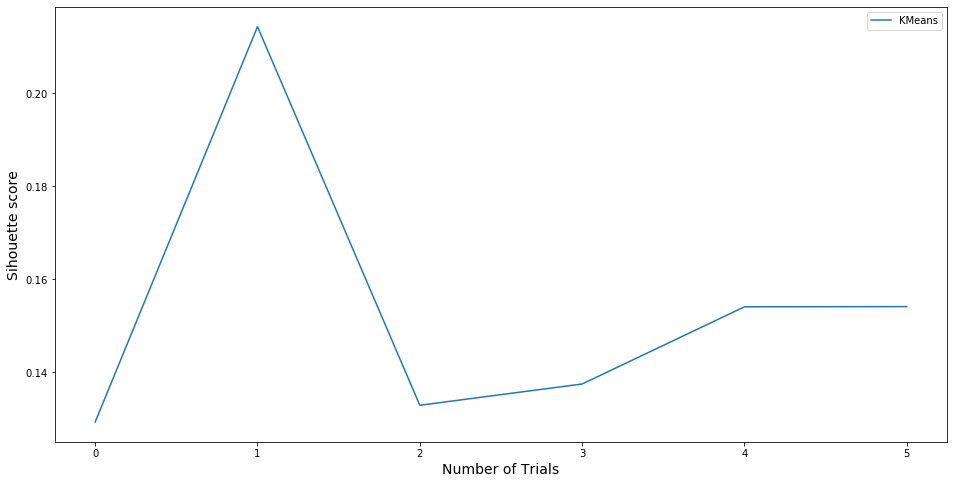

In [53]:
# unique_id = user_log.iloc[:,0:1]
# data = user_log.iloc[:,1:]
k_range = np.arange(2,8) # should start with 2 cluster at least
# clustering_scores = pd.DataFrame()
seed = 4103

user_log = clustering_input.reset_index()

from clustering_utils.clustering_pipeline import bt4103Clustering
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS, Birch, AffinityPropagation
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import GaussianMixture

CC = bt4103Clustering(user_log)
CC.create_algo_input(inputs = [(KMeans, {'random_state':seed}, ('n_clusters', k_range)),
#          (GaussianMixture, {'random_state':seed}, ('n_components', k_range)),
                              ]
    )
CC.clustering_preprocessing(n_components=0.99)
scores, unique_id = CC.run_clustering_pipeline()
CC.silhouette_analysis()

In [56]:
best_model_col = [col for col in CC.clustering_groups if CC.best_model.__class__.__name__ in col]
user_log['best_cluster'] = CC.clustering_groups[best_model_col]
user_log['best_cluster'].value_counts()

2    52694
0    19576
1      488
Name: best_cluster, dtype: int64

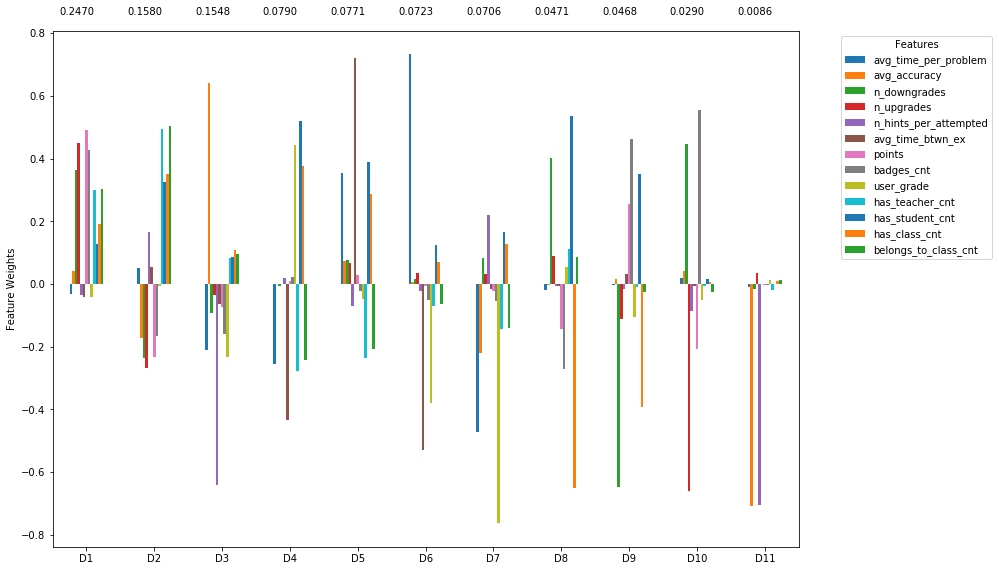

In [57]:
CC.preprocessor.plot_pca_result()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

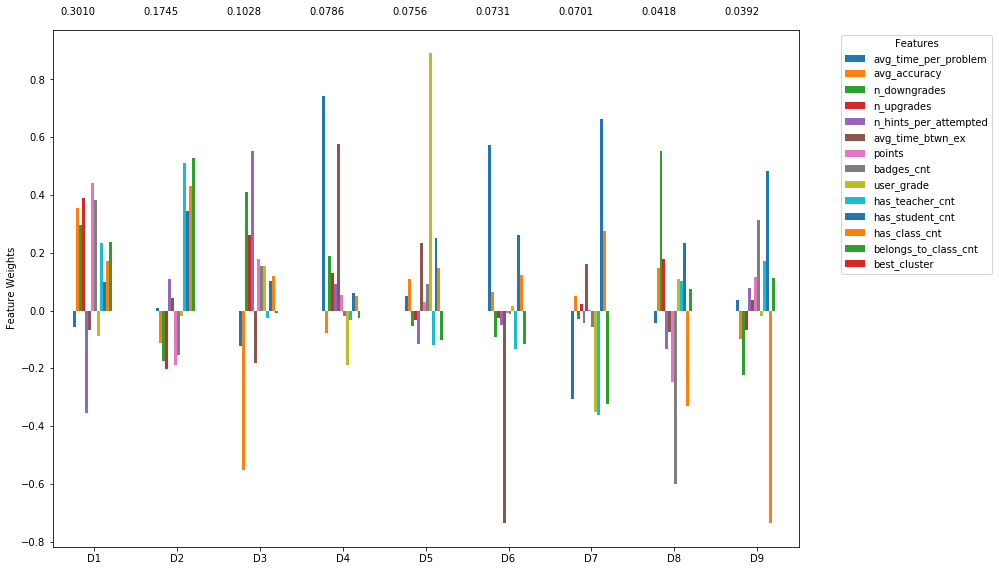

In [112]:
# PCA(random_state = 2).fit(user_log[user_log['best_cluster']==1].iloc[:,1:]).explained_variance_ratio_
# fig, ax = plt.subplots(3,1, figsize=(16,4))
bt4103Preprocessor(user_log[user_log['best_cluster']==0].iloc[:,1:]).plot_pca_result(n_components=0.95, seed=3124)

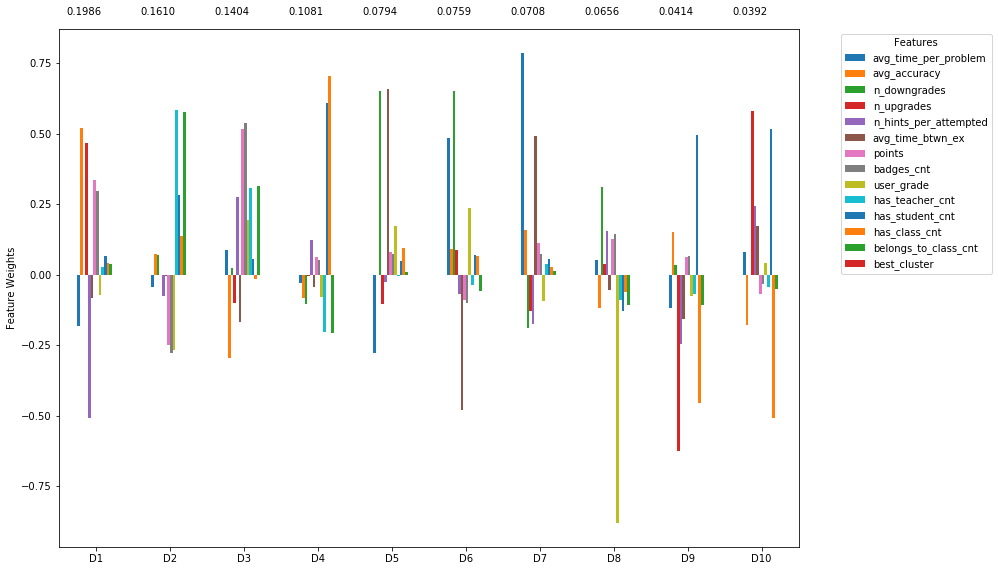

In [67]:
from sklearn.decomposition import PCA
from clustering_utils.clustering_preprocessor import bt4103Preprocessor

# PCA(random_state = 2).fit(user_log[user_log['best_cluster']==1].iloc[:,1:]).explained_variance_ratio_
bt4103Preprocessor(user_log[user_log['best_cluster']==1].iloc[:,1:]).plot_pca_result(n_components=0.95, seed=3124)

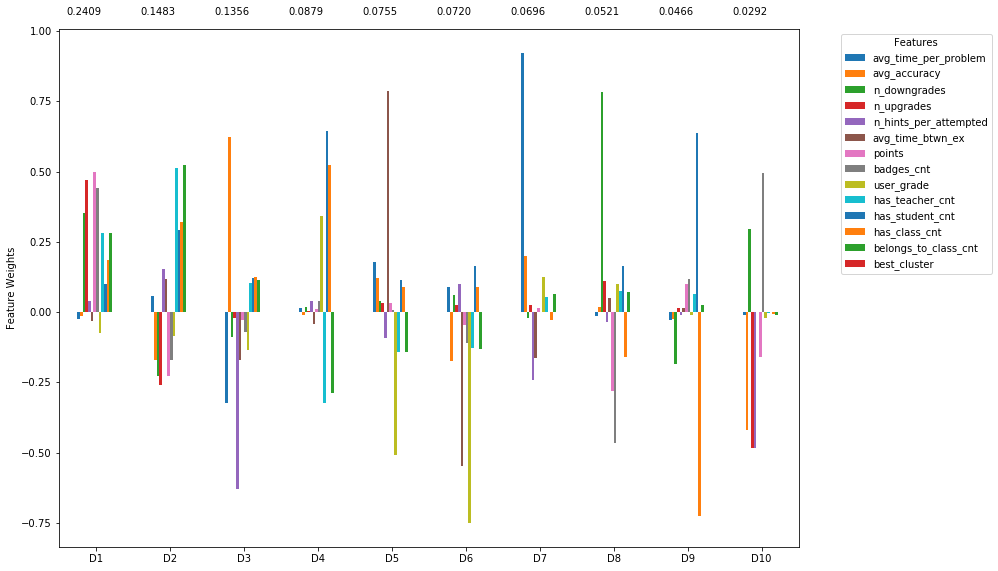

In [70]:
from sklearn.decomposition import PCA
# PCA(random_state = 2).fit(user_log[user_log['best_cluster']==1].iloc[:,1:]).explained_variance_ratio_
bt4103Preprocessor(user_log[user_log['best_cluster']==2].iloc[:,1:]).plot_pca_result(n_components=0.95, seed=3124)

In [ ]:
# unique_id = user_log.iloc[:,0:1]
# data = user_log.iloc[:,1:]
k_range = np.arange(2,8) # should start with 2 cluster at least
# clustering_scores = pd.DataFrame()
seed = 4103

user_log = clustering_input.reset_index()

from clustering_utils.clustering_pipeline import bt4103Clustering
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS, Birch, AffinityPropagation
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import GaussianMixture

CC = bt4103Clustering(user_log)
CC.create_algo_input(inputs = [(KMeans, {'random_state':seed}, ('n_clusters', k_range)),
#          (GaussianMixture, {'random_state':seed}, ('n_components', k_range)),]
    )
CC.clustering_preprocessing(n_components=0.99)
scores, unique_id = CC.run_clustering_pipeline()
CC.silhouette_analysis()

In [38]:
from clustering_utils.clustering_preprocessor import bt4103Preprocessor
CC.preprocessor.plot_pca_result()

### Look at the silhouette scores from the clusters

In [24]:
CC.clustering_scores

,KMeans_hparams,KMeans,GaussianMixture_hparams,GaussianMixture
0,n_clusters_2,0.351970,n_components_2,0.374023
1,n_clusters_3,0.353502,n_components_3,0.112227
2,n_clusters_4,0.389249,n_components_4,0.110720
3,n_clusters_5,0.402867,n_components_5,0.029889
4,n_clusters_6,0.273296,n_components_6,0.047018
5,n_clusters_7,0.280637,n_components_7,0.010540


### Clusters of 5 is the best for KMeans, while 2 is the best for GMMs

In [23]:
CC.clustering_groups

,uuid,KMeans_n_clusters_5,GaussianMixture_n_components_2
0,++5bdNp/LZvGenJ8Brp4n2SfS9d4pu4qA7cF7FQW7hk=,4,0
1,++9EkR6syMGk44XpyhOj40cg9xiXwCLS/TwEy+ujrL0=,1,1
2,++E4TrlDYvGtPBg1edhkLXLEEbnfiAgAamPQ33vpW8M=,4,0
3,++G4mkLfs4WDYhc1Ga+3G+/oqSniQQvLBm7SBQ3V39Y=,1,1
4,++GobOSWqrsaxoRg1bMN+T6biIJcgBXwuOH/ddq3DiU=,4,0
...,...,...,...
72753,zztwLsjf44Uzumou84qh04wObpugkIllLCIp/mgoMu8=,0,1
72754,zzueVRV14tXIEgW4ixiqmtPNaFYz4MIifbMM/H2tmqA=,2,1
72755,zzujjvdKzb4wL8cFKdF3Of5gg2XHzIDQCZ2TfaYpSNs=,4,0
72756,zzvvUOwcSXXTXd8xoyimNcm2DjeVPLmZAI19WKfhSAM=,4,0


In [27]:
CC.clustering_scores.to_csv("user_log_clustering_scores.csv", index=False)
CC.clustering_groups.to_csv("user_log_clustering_groups.csv", index=False)

In [28]:
log.head()

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,is_downgrade,is_upgrade,level
0,2019-05-26 21:00:00 UTC,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,Vbs92l4JmdiWkUEm/iahxnUTaac2oN1IlUtXB7JcfoE=,18,2,True,33,1,0,False,False,True,3
1,2019-05-17 16:30:00 UTC,+Gqj2nalc6M9fusyVECTC0AN7UQdDQTXESIuElkDltU=,COZ39Wo+uIUO2s7c2VGEHjJf6Vx0xifxVAiaeHtaTdk=,Ek+pIeHNNoEo0tGEq91eBcBmGgy3+A5RWhpj95zTyHM=,4,1,True,8,1,0,False,NaN,NaN,0
2,2019-05-15 19:15:00 UTC,6D5QN8j8ng/VR74ES3A0zqAj0bIFFyaKjKEj8ZyXjQ8=,TwyqyV1uJYlDAX8wX/PtTCVZEBo/APIVfTzzleGkNCQ=,1MBa2f5Qog4JBoAuUfJf0fxeJctdEirAqKgfsg246eI=,9,1,True,17,1,0,False,NaN,NaN,0
3,2019-05-05 14:45:00 UTC,GgTZuCqZXObthtK6GAwqvlHrTMm5pKHWeezQxL/pcKc=,tBo6ECyT8IlKAM8UhQHWkqv92PRLcSiwuerfC7vNX+w=,kdMy2nG+QVMjPkuaMEWs0yV/sYZVoG1vm7zM0fCy+qk=,2,1,True,10,1,0,False,NaN,NaN,0
4,2019-05-14 16:45:00 UTC,JMNKWoU0CkMSzgQ8bCnmCYlD8jEzAVge3lHMYLXKM2g=,vVpSKAMQbTMvtdERR0ksOeRmmaFt0R210t4Z//0RpPA=,jjPR8fmkLSFoCQQYB4g6kI8mgdcK3sKtMirKUvfmZIk=,6,1,True,98,1,0,False,NaN,NaN,0


In [29]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16217311 entries, 0 to 16217310
Data columns (total 14 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   timestamp_TW                     object
 1   uuid                             object
 2   ucid                             object
 3   upid                             object
 4   problem_number                   int64 
 5   exercise_problem_repeat_session  int64 
 6   is_correct                       bool  
 7   total_sec_taken                  int64 
 8   total_attempt_cnt                int64 
 9   used_hint_cnt                    int64 
 10  is_hint_used                     bool  
 11  is_downgrade                     object
 12  is_upgrade                       object
 13  level                            int64 
dtypes: bool(2), int64(6), object(6)
memory usage: 1.5+ GB


In [31]:
log.isnull().sum()

timestamp_TW                              0
uuid                                      0
ucid                                      0
upid                                      0
problem_number                            0
exercise_problem_repeat_session           0
is_correct                                0
total_sec_taken                           0
total_attempt_cnt                         0
used_hint_cnt                             0
is_hint_used                              0
is_downgrade                       14436018
is_upgrade                         14436018
level                                     0
dtype: int64

In [30]:
log['timestamp_TW']= pd.to_datetime(log['timestamp_TW'])

In [32]:
log_problem = log

In [ ]:
log.groupby(['uuid','ucid'])['timestamp_TW'].apply(lambda x: (max(x) - min(x)) / len(x))

In [ ]:

# shift cols down by 1
log_problem['ucid_shifted'] = log_problem.groupby(by='uuid', sort=False)['ucid'].shift(1)
log_problem['timestamp_shifted'] = log_problem.groupby(by='uuid', sort=False)['timestamp_TW'].shift(1)

In [ ]:
# shift cols down by 1
log_problem['ucid_shifted'] = log_problem.groupby(by='uuid', sort=False)['ucid'].shift(1)
log_problem['timestamp_shifted'] = log_problem.groupby(by='uuid', sort=False)['timestamp_TW'].shift(1)
log_problem[log_problem['uuid']==log_problem['uuid'][100]][['timestamp_TW', 'timestamp_shifted', 'ucid', 'ucid_shifted']]


In [ ]:

# keep relevant rows
mask = (log_problem['ucid']!=log_problem['ucid_shifted']) & (log_problem['ucid_shifted'].notna())
relevant_logs = log_problem[mask]

# find time diff
relevant_logs['time_diff'] = (relevant_logs['timestamp_TW'] - relevant_logs['timestamp_shifted']).dt.total_seconds()


In [ ]:
relevant_logs.groupby(['ucid'])['time_diff'].apply(lambda x: (max(x) - min(x)) / len(x))